# DIMENSION REDUCTION WITH AUTOENCODERS

<font size="5">*Joe Hellerstein*, Research Scientist, eScience Institute</font>

**Motivation**

We often want to reduce the dimensionality of data
* *Data Analysis*: Focus on a few important variables
* *Dynamical Systems*: Visualize dynamics (e.g., in 2d)
* *Image Processing*: Compress data into essential pixels

Dimension reduction is crucial in machine learning for simplifying complex data sets (Van Der Maaten et al. 2009), reducing computational complexity (Ray et al. 2021), and mitigating the curse of dimensionality (Talpur et al. 2023), ultimately improving model performance and interpretability. Dimension reduction encompasses two primary approaches: feature selection (Solorio-Fernández et al. 2022), which involves choosing a subset of the most informative features from the original data-set to reduce dimensionality while maintaining interpretability; and feature extraction (Li et al. 2022), a method where new, lower-dimensional features are derived from the original data to capture essential patterns and relationships.

Autoencoders and their applications in machine learning: a survey  Kamal Berahmand1 · Fatemeh Daneshfar2 · Elaheh Sadat Salehi3 · Yuefeng Li1 · Yue Xu1, Artificial Intelligence Review (2024)

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/feature_extraction.png" 
         alt="Types of feature extractiom."
         width="600">

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/generic_autoencoder.png" 
         alt="Generic autoencoder"
         width="400">

* Same number of nodes in the input and output layers
* Hidden layer has fewer nodes
* May be many hidden layers.
* If many hidden layers.
* * An even number. First half is **encoder**; second is **decoder**

We will focus on the task of compression initially.

# Preliminaries

In [1]:
import collections
import io
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
import pandas as pd
import os
from typing import Tuple, List, Optional
from torchvision import datasets
import zipfile

In [2]:
DATA_DIR = "/Users/jlheller/home/Technical/repos/pixel_proficiency/data"
NUM_TRAIN = 60000
NUM_TEST = 10000

In [3]:
# Load and preprocess MNIST data
(X_TRAIN, LABEL_TRAIN), (X_TEST, LABEL_TEST) = mnist.load_data()  # Only done if data are not local

In [4]:
LABEL_TRAIN

array([5, 0, 4, ..., 5, 6, 8], shape=(60000,), dtype=uint8)

# Helpers

## Constants

In [5]:
ANIMALS_PATH = "animals.pkl"
MNIST_PATH = "mnist.pkl"

In [6]:
TrainTestData = collections.namedtuple('TrainTestData', ['x_train', 'label_train', 'x_test', 'label_test', 'class_names'])
# x_train: np.ndarray (training data)
# label_train: np.ndarray (training labels)
# x_test: np.ndarray (test data)
# label_test: np.ndarray (test labels)
# class_names: List[str] (class names)

## getPklAnimals

In [7]:
def getPklAnimals() -> TrainTestData:
    """Recovers Animals image data from pickle files, or pickles the data if not present.

    Returns:
        TrainTestData: A named tuple containing training and test data and labels.
    """
    ##
    data_dir = "/Users/jlheller/home/Technical/repos/pixel_proficiency/data/animals"
    def getData(data_type: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        dataset = datasets.STL10(root=data_dir, split=data_type, download=True)
        class_names = dataset.classes  # List of class names
        images = []
        labels = []
        for img, label in dataset:
            images.append(np.array(img))
            labels.append(label)
        images_array = np.stack(images)  # Shape: (N, 96, 96, 3)
        labels_array = np.array(labels)  # Shape: (N,)
        return images_array, labels_array, class_names
    ##
    if not os.path.exists(ANIMALS_PATH):
        print("***Pickling Animals data...")
        train_image_arr, train_label_arr, class_names = getData('train')
        test_image_arr, test_label_arr, class_names = getData('test')
        data = (train_image_arr, train_label_arr, test_image_arr, test_label_arr, class_names)
        with open(ANIMALS_PATH, 'wb') as f:
            pickle.dump(data, f)
    else:
        print("***Unpickling Animals data...")
        with open(ANIMALS_PATH, 'rb') as f:  # type: ignore
            train_image_arr, train_label_arr, test_image_arr, test_label_arr, class_names = pickle.load(f)
    return TrainTestData(train_image_arr, train_label_arr, test_image_arr, test_label_arr, class_names)

In [8]:
X_ANIMAL_TRAIN, LABEL_ANIMAL_TRAIN, X_ANIMAL_TEST, LABEL_ANIMAL_TEST, ANIMAL_CLASS_NAMES = getPklAnimals()

***Unpickling Animals data...


In [9]:
np.shape(X_ANIMAL_TRAIN)

(5000, 96, 96, 3)

## getPklMNIST

In [10]:

def getPklMNIST() -> TrainTestData:
    """Recovers MNIST image data from pickle files, or pickles the data if not present.

    Returns:
        TrainTestData: A named tuple containing training and test data and labels.
    """
    if not os.path.exists(MNIST_PATH):
        print("***Pickling MNIST data...")
        (x_train, label_train), (x_test, label_test) = mnist.load_data()
        data = (x_train, label_train, x_test, label_test)
        with open(MNIST_PATH, 'wb') as f:
            pickle.dump(data, f)
    else:
        print("***Unpickling MNIST data...")
        with open(MNIST_PATH, 'rb') as f:
            x_train, label_train, x_test, label_test = pickle.load(f)
    class_names = [str(i) for i in range(10)]
    return TrainTestData(x_train, label_train, x_test, label_test, class_names)

In [11]:
X_MNIST_TRAIN, LABEL_MNIST_TRAIN, X_MNIST_TEST, LABEL_MNIST_TEST, MNIST_CLASS_NAMES = getPklMNIST()

***Unpickling MNIST data...


In [12]:
np.shape(X_MNIST_TRAIN)

(60000, 28, 28)

## visualize

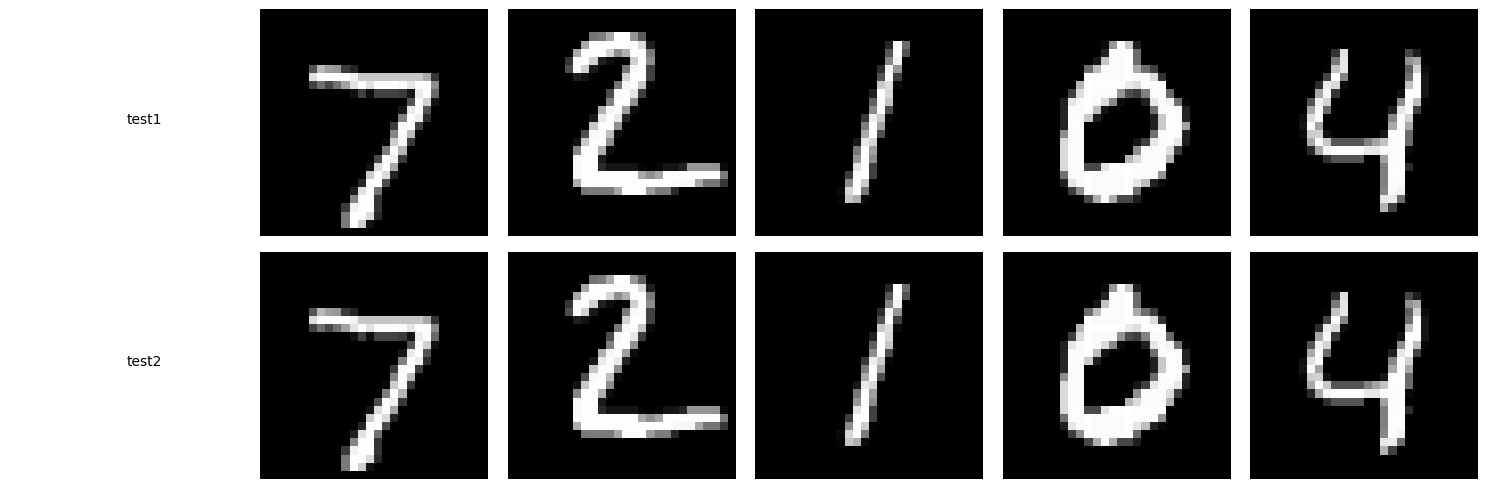

OK!


In [13]:
def visualize(arrs: np.ndarray, num_image: int, titles: str = "", figsize=(15, 5)):
    # Displays one or more digits
    num_row = len(arrs)
    _, axes =  plt.subplots(num_row, num_image + 1, figsize=figsize)
    for irow, arr in enumerate(arrs):
        ax = axes[irow, 0]
        ax.text(0.5, 0.5, titles[irow])
        ax.axis('off')
        for i in range(num_image):
            # Original images
            #ax = plt.subplot(1, num_image + 1, i + 2)
            ax = axes[irow, i+1]
            ax.imshow(arr[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Test
visualize([X_TEST, X_TEST], 5, titles=["test1", "test2"])
#plt.close()
print("OK!")

## zipCompressArray

In [14]:
# Method 1: Using BytesIO with zipfile
def zipCompressArray(arr):
    """Compress numpy array to zip in memory"""
    # Create in-memory bytes buffer
    zip_buffer = io.BytesIO()
    
    # Create zip file in memory
    with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        # Save array to bytes
        arr_bytes = io.BytesIO()
        np.save(arr_bytes, arr)
        arr_bytes.seek(0)
        
        # Write to zip
        zip_file.writestr('array.npy', arr_bytes.read())
    
    # Get compressed data
    zip_buffer.seek(0)
    return zip_buffer

# Test
arr = np.random.rand(1000, 1000)
compressed = zipCompressArray(arr)
assert(len(compressed.getvalue()) < arr.nbytes)
print("OK!")

OK!


# Data Preparation

In [15]:
X_MNIST_TRAIN = X_MNIST_TRAIN.reshape((len(X_MNIST_TRAIN), 28 * 28))
X_MNIST_TEST = X_MNIST_TEST.reshape((len(X_MNIST_TEST), 28 * 28))
np.shape(X_MNIST_TRAIN), np.shape(X_MNIST_TEST)

((60000, 784), (10000, 784))

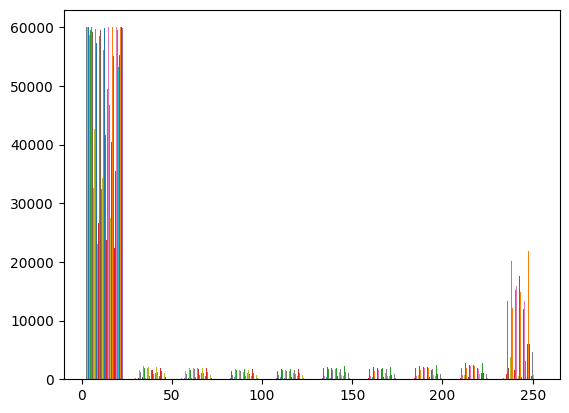

In [16]:
_ = plt.hist(X_MNIST_TRAIN)

# zip compression

zip compression is lossless. It is achieved by clever encoding of the data: Use the shortest encodings for values that occur most frequently.

In [17]:
compressed = zipCompressArray(X_MNIST_TRAIN)  # See Helpers for this function
num_uncompressed_mbyte = X_MNIST_TRAIN.nbytes/1e6
num_compressed_mbyte = len(compressed.getvalue())/1e6
print(f"Uncompressed size of MNIST training data: {num_uncompressed_mbyte} MB")
print(f"Compressed size of MNIST training data: {num_compressed_mbyte} MB")
print(f"Compression ratio: {num_uncompressed_mbyte/num_compressed_mbyte}")

Uncompressed size of MNIST training data: 47.04 MB
Compressed size of MNIST training data: 9.822183 MB
Compression ratio: 4.789159395625188


***Lossless compression provides a lower bound for dimension reduction.***

# Principal Component

* Lossy compression by extracting dominant effects
* Assumes linearity

In [19]:
def generatePCA(arr: np.ndarray, n_component: int) -> Tuple[np.ndarray, str]:
    pca = PCA(n_components=n_component, random_state=42)
    pca.fit(arr)
    x_reduced = pca.transform(arr)
    x_decoded = pca.inverse_transform(x_reduced)
    title = f"PCA/{n_component}"
    return x_decoded, title

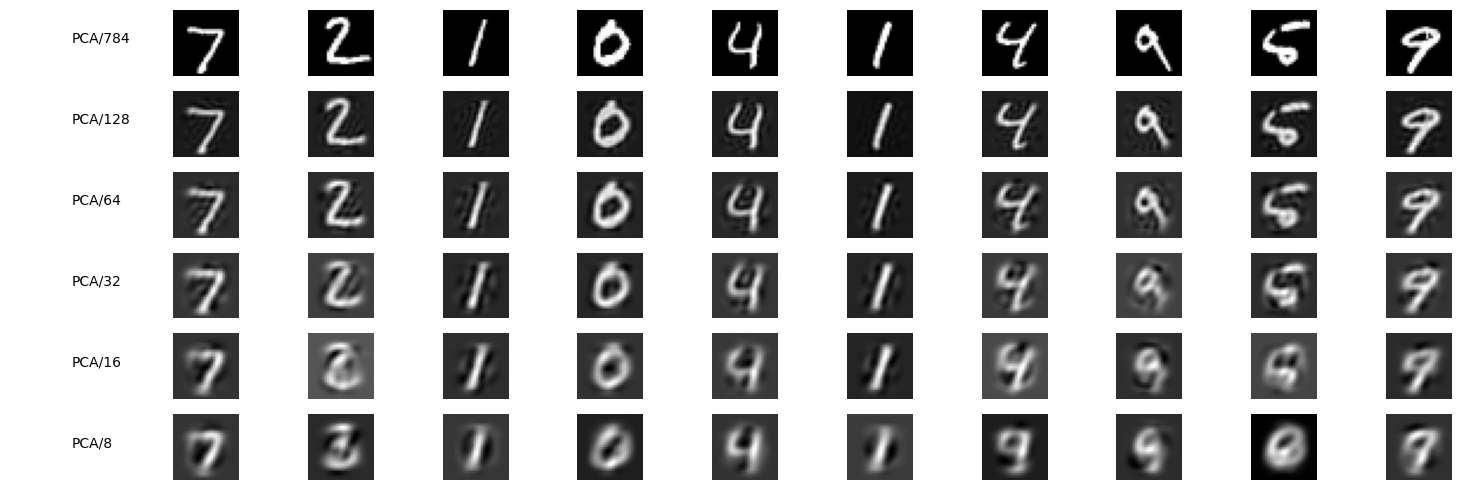

Compression ratios
784: 1.0
128: 6.125
64: 12.25
32: 24.5
16: 49.0
8: 98.0


In [25]:
sizes = [28*28, 128, 64, 32, 16, 8]
results = [generatePCA(X_MNIST_TEST, n) for n in sizes]
arrs = [r[0] for r in results]
titles = [r[1] for r in results]
visualize(arrs, 10, titles=titles)
#
print("Compression ratios")
for size in sizes:
    print(f"{size}: {784/size}")

# Dense Autoencoder

## What is an autoencoder?

## Normalize the data by dividing by the maximum value

In [ ]:
np.max(X_MNIST_TRAIN), np.max(X_MNIST_TEST)

In [ ]:
X_MNIST_TRAIN = X_MNIST_TRAIN/255
X_MNIST_TEST = X_MNIST_TEST/255

## Implementing a dense autoencoder in Keras

In [ ]:
# Define autoencoder architecture
encoding_dim = 16
print(f"Compression factor is {784/encoding_dim}")

# Input layer
input_img = keras.Input(shape=(784,))

# Encoder
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create encoder model (for extracting encoded representations)
encoder = keras.Model(input_img, encoded)

# Create decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
decoder = keras.Model(encoded_input,
                     decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Display model architecture
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(X_TRAIN, X_TRAIN,
                         epochs=15,
                         batch_size=256,
                         shuffle=True,
                         validation_data=(X_TEST, X_TEST),
                         verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate predictions
encoded_imgs = encoder.predict(X_TEST)
decoded_imgs = autoencoder.predict(X_TEST)

# Visualize results
plt.subplot(1, 2, 2)
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_TEST[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print compression statistics
print(f"\nOriginal image size: 784 pixels")
print(f"Encoded representation size: {encoding_dim} values")
print(f"Compression ratio: {784/encoding_dim:.1f}:1")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Optional: Save the trained model
# autoencoder.save('mnist_autoencoder.h5')
# encoder.save('mnist_encoder.h5')
# decoder.save('mnist_decoder.h5')

## Evaluating compressions achieved

# Convolutional Autoencoder

In [ ]:
# Prepare the data
X_TRAIN, X_TEST = util.getPklMNIST()
# Reshape to add channel dimension (28, 28, 1) for CNN
X_TRAIN = np.expand_dims(X_TRAIN, -1)
X_TEST = np.expand_dims(X_TEST, -1)

print(f"Training data shape: {X_TRAIN.shape}")
print(f"Test data shape: {X_TEST.shape}")

In [ ]:
9*16

In [ ]:
# Define the Autoencoder

# Define convolutional autoencoder architecture
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

print(f"Encoded shape: {encoded.shape}")

# Decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = keras.Model(input_img, decoded)

# Create encoder model (for extracting encoded representations)
encoder = keras.Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# Display model architecture
autoencoder.summary()

In [ ]:

# Train the autoencoder
history = autoencoder.fit(X_TRAIN, X_TRAIN,
                         epochs=1,
                         batch_size=128,
                         shuffle=True,
                         validation_data=(X_TEST, X_TEST),
                         verbose=1)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Generate predictions
encoded_imgs = encoder.predict(X_TEST)
decoded_imgs = autoencoder.predict(X_TEST)

print(f"Encoded representation shape: {encoded_imgs.shape}")

# Visualize some encoded feature maps
plt.subplot(1, 3, 3)
plt.imshow(encoded_imgs[0, :, :, 0], cmap='viridis')
plt.title('Encoded Feature Map (Channel 0)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Visualize original vs reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))

for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_TEST[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    # Difference (error map)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    diff = np.abs(X_TEST[i] - decoded_imgs[i])
    plt.imshow(diff.reshape(28, 28), cmap='hot')
    plt.title("Difference")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate reconstruction error statistics
mse = np.mean((X_TEST - decoded_imgs) ** 2)
mae = np.mean(np.abs(X_TEST - decoded_imgs))

print(f"\nReconstruction Statistics:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Analyze compression
original_size = 28 * 28 * 1  # 784 parameters per image
encoded_size = encoded_imgs.shape[1] * encoded_imgs.shape[2] * encoded_imgs.shape[3]
compression_ratio = original_size / encoded_size

print(f"\nCompression Analysis:")
print(f"Original image size: {original_size} pixels")
print(f"Encoded representation: {encoded_imgs.shape[1]}x{encoded_imgs.shape[2]}x{encoded_imgs.shape[3]} = {encoded_size} values")
print(f"Compression ratio: {compression_ratio:.1f}:1")

# Optional: Visualize learned filters from the first convolutional layer
def visualize_conv_filters(model, layer_idx=1, num_filters=16):
    """Visualize the learned convolutional filters"""
    filters = model.layers[layer_idx].get_weights()[0]

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f'Learned Filters from Layer {layer_idx}')

    for i in range(min(num_filters, 16)):
        ax = axes[i//4, i%4]
        ax.imshow(filters[:, :, 0, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize learned filters
visualize_conv_filters(autoencoder)

# Applications of Autoencoders

## Efficient classification

## Generation

### New bird

### Truck bird

# Animal Images

In [ ]:
data_dir = "/Users/jlheller/home/Technical/repos/pixel_proficiency/data/animals"
stl10 = datasets.STL10(root=data_dir, split='train', download=True)

In [ ]:
img = np.reshape(np.array(stl10[0][0]).flatten(), (96, 96, 3))
plt.imshow(np.array(img))

In [ ]:
img, label = stl10[100]
plt.imshow(np.array(img))
plt.title(f"Label: {label}")
plt.show()

In [ ]:
stl10_classes = [
    'airplane',
    'bird',
    'car',
    'cat',
    'deer',
    'dog',
    'horse',
    'monkey',
    'ship',
    'truck'
]

In [ ]:
num_row = 10
num_col = 10
_, axes = plt.subplots(num_row, num_col, figsize=(10, 15))
for irow in range(num_row):
    for icol in range(num_col):
        idx = irow*num_col + icol
        ax = axes[irow, icol]
        img, label = stl10[idx]
        ax.imshow(np.array(img))
        name = stl10_classes[int(label)]
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
        

## Convert to grey scale

In [ ]:
image, _ = stl10[0]
gray_img = image.convert('L')  
arr = np.array(gray_img)
np.shape(arr)
plt.imshow(arr)
plt.figure()
plt.imshow(np.array(image))

# Masked Autoencoder

In [ ]:
# Prepare the data
X_TRAIN, X_TEST = util.getPklMNIST()
# Reshape to add channel dimension (28, 28, 1) for CNN
X_TRAIN = np.expand_dims(X_TRAIN, -1)
X_TEST = np.expand_dims(X_TEST, -1)

print(f"Training data shape: {X_TRAIN.shape}")
print(f"Test data shape: {X_TEST.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf

# Load MNIST dataset
if False:
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    
    # Normalize to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Reshape to add channel dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
else:
    x_train = X_TRAIN
    x_test = X_TEST

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

# Masking function
def create_mask(batch_size, img_size=28, patch_size=4, mask_ratio=0.75):
    """
    Creates a random mask for patches.
    Args:
        batch_size: Number of images in batch
        img_size: Size of image (28 for MNIST)
        patch_size: Size of each patch
        mask_ratio: Ratio of patches to mask
    Returns:
        mask: Binary mask (1 = visible, 0 = masked)
    """
    num_patches = (img_size // patch_size) ** 2
    num_masked = int(mask_ratio * num_patches)
    
    masks = []
    for _ in range(batch_size):
        # Random indices to mask
        mask_indices = np.random.choice(num_patches, num_masked, replace=False)
        mask = np.ones(num_patches)
        mask[mask_indices] = 0
        masks.append(mask)
    
    return np.array(masks)

def apply_mask_to_image(images, masks, patch_size=4):
    """
    Applies patch-based mask to images.
    """
    batch_size = images.shape[0]
    img_size = images.shape[1]
    num_patches_side = img_size // patch_size
    
    masked_images = images.copy()
    
    for i in range(batch_size):
        mask = masks[i].reshape(num_patches_side, num_patches_side)
        for p_y in range(num_patches_side):
            for p_x in range(num_patches_side):
                if mask[p_y, p_x] == 0:
                    y_start = p_y * patch_size
                    x_start = p_x * patch_size
                    masked_images[i, y_start:y_start+patch_size, 
                                x_start:x_start+patch_size, :] = 0
    
    return masked_images

# Build Masked Autoencoder
def build_masked_autoencoder(input_shape=(28, 28, 1)):
    """
    Builds a convolutional masked autoencoder.
    """
    # Encoder
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Output layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Crop to match input size if needed
    decoded = layers.Cropping2D(cropping=((2, 2), (2, 2)))(decoded)
    
    autoencoder = keras.Model(inputs, decoded, name='masked_autoencoder')
    return autoencoder

# Create model
model = build_masked_autoencoder()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Data generator for training with random masking
class MaskedDataGenerator(keras.utils.Sequence):
    def __init__(self, x_data, batch_size=128, mask_ratio=0.75, patch_size=4):
        self.x_data = x_data
        self.batch_size = batch_size
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.indices = np.arange(len(x_data))
        
    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x_data[batch_indices]
        
        # Create masks and apply them
        masks = create_mask(len(batch_x), mask_ratio=self.mask_ratio, 
                          patch_size=self.patch_size)
        masked_x = apply_mask_to_image(batch_x, masks, patch_size=self.patch_size)
        
        return masked_x, batch_x  # Input: masked, Target: original
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Create data generators
train_gen = MaskedDataGenerator(x_train, batch_size=128, mask_ratio=0.75)
val_gen = MaskedDataGenerator(x_test, batch_size=128, mask_ratio=0.75)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    verbose=1
)

# Visualize results
def visualize_results(model, x_test, num_images=5, mask_ratio=0.75, patch_size=4):
    """
    Visualizes original, masked, and reconstructed images.
    """
    # Select random images
    indices = np.random.choice(len(x_test), num_images, replace=False)
    test_images = x_test[indices]
    
    # Create masks and masked images
    masks = create_mask(num_images, mask_ratio=mask_ratio, patch_size=patch_size)
    masked_images = apply_mask_to_image(test_images, masks, patch_size=patch_size)
    
    # Reconstruct
    reconstructed = model.predict(masked_images, verbose=0)
    
    # Plot
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 3*num_images))
    
    for i in range(num_images):
        # Original
        axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # Masked
        axes[i, 1].imshow(masked_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Masked ({int(mask_ratio*100)}%)')
        axes[i, 1].axis('off')
        
        # Reconstructed
        axes[i, 2].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Reconstructed')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(model, x_test, num_images=5, mask_ratio=0.75)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Notes

1. Do classification using encoded representation to reduce computation cost
2. Consider doing the autoencoding on the zip data
3. Tuning hyperparameters: batch size, number of epochs, activation (use same for each step?)
4. Using GPU
5. Debugging quality - what layers? what activations?
6. Choice of objective function.
7. Debugging layer shapes
8. Data preparation
9.   1. Normalize to create values between 0 and 1
10. Design
11.   1. Be consistent on the activations. If an encoder layer uses 'relu', the corresponding decoder layer should as well.
12. Tuning
13.  1. Need enough batches of sufficient size, approx 100. At least 30-40 batches
14.  2. Start with less compression and then go to more
15. Pro tips
    1. ``EarlyStopping``
    2. ``ReduceLROnPlateau``
    3. ``ModelCheckpoint``